In [ ]:
!pip install mat73

In [ ]:
import mat73
import scipy
import scipy.io as sio # cannot use for v7.3 mat file
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import butter, filtfilt, sosfiltfilt

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# filters

def butter_lowpass_filter(data, lowcut, fs, order):
    nyq = fs/2
    low = lowcut/nyq
    b, a = butter(order, low, btype='low')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

def butter_highpass_filter(data, highcut, fs, order):
    nyq = fs/2
    high = highcut/nyq
    b, a = butter(order, high, btype='high')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = fs/2
    low = lowcut/nyq
    high = highcut/nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = sosfiltfilt(sos, data) # zero-phase filter # data: [ch x time]
    # specify pandlen to make the result the same as Matlab filtfilt()
    return y

In [ ]:
#Pre processing

def extractEpoch3D(data, event, srate, baseline, frame, opt_keep_baseline):
    # extract epoch from 2D data into 3D [ch x time x trial]
    # input: event, baseline, frame
    # extract epoch = baseline[0] to frame[2]   so the time frame is -200 to 600 ms.

    # for memory pre-allocation
    if opt_keep_baseline == True:
        begin_tmp = int(np.floor(baseline[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
    else:
        begin_tmp = int(np.floor(frame[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)

    epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
    nth_event = 0 # trial

    for i in event:
        if opt_keep_baseline == True:
            begin_id = int(i + np.floor(baseline[0]/1000 * srate))                 # int(i + begin_tmp)
            end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))   # int(i + end_tmp)
        else:
            begin_id = int(i + np.floor(frame[0]/1000 * srate))
            end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))

        tmp_data = data[:, begin_id:end_id] # extract the time period

        begin_base = int(np.floor(baseline[0]/1000 * srate))+i
        end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)
        base = np.mean(data[:, begin_base:end_base], axis=1)

        rmbase_data = tmp_data - base[:, np.newaxis]
        epoch3D[:, :, nth_event] = rmbase_data
        nth_event = nth_event + 1

    return epoch3D

def decimation_by_avg(data, factor):
    """Function for replacing each sequence of previous factor samples with their average"""
    # for example, frame [0, 800]ms -> 17samples (Krusienski et al., 2006)
    # data.shape = [ch, time, trial]
    ratio_dsample = factor
    n_ch, n_frame, n_trial = data.shape

    print("n_frame" ,n_frame)
    decimated_frame = int(np.floor(n_frame/ratio_dsample))
    print("decimated_frame ",decimated_frame)

    # memory pre-allocation
    decimated_data = np.zeros((n_ch, decimated_frame, n_trial))
    print("decimated_data.shape ",decimated_data.shape)

    for i in range(n_trial):
        for j in range(decimated_frame):
            cur_data = data[:, :, i]
            decimated_data[:, j, i] = np.mean(cur_data[:, j*ratio_dsample:(j+1)*ratio_dsample], axis=1)

    return decimated_data

def detect_letter_P3speller(pred_score, word_len, label, letter_ind, markers_seq, params):
    """Function for detecing letter from the predicted results from unknown EEG"""
    user_answer = np.chararray(word_len,1)
    acc_on_repetition = np.zeros(params["full_repeat"])
    correct_on_repetition = np.zeros(params["full_repeat"])
    for n_repeat in range(params["full_repeat"]):
        for n_letter in range(word_len):
            # begin and end trial for a single letter session
            begin_trial = len(params["seq_code"]) * params["full_repeat"] * (n_letter)
            end_trial = begin_trial + (n_repeat+1) * len(params["seq_code"])

            unknown_speller_code = np.zeros(len(params["seq_code"]))
            for j in range(begin_trial, end_trial):
                # predict and add lda score
                unknown_speller_code[int(markers_seq[letter_ind[j]])-1] = unknown_speller_code[int(markers_seq[letter_ind[j]])-1] + pred_score[j]

            row = np.argmax(unknown_speller_code[0:6])
            col = np.argmax(unknown_speller_code[6:12])
            user_answer[n_letter] = params['spellermatrix'][row*6+col]
        user_answer_string = user_answer.tobytes().decode()

        correct_on_repetition[n_repeat] = len([i for i, j in zip(user_answer_string, label) if i == j])
        acc_on_repetition[n_repeat] = correct_on_repetition[n_repeat] / len(label)

    out = {"text_result": user_answer_string, "acc_on_repetition": acc_on_repetition, "correct_on_repetition": correct_on_repetition}
    return out

In [ ]:
# pre-defined parameters
baseline = [-200, 0] # in ms
frame = [0, 600] # in ms

In [ ]:
EEG = mat73.loadmat("/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/s01.mat")

# **Code for prediction letters**

In [ ]:
#Load Dataset

EEG_data = []
path = "/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/"
for subject in range(1,5):
  try:
    eeg = mat73.loadmat(path+'s{:02d}.mat'.format(int(subject)))
    EEG_data += eeg['train'] + eeg['test']
  except Exception as e:
    print(subject, " is not a MATLAB 7.3 file.")
#Pre-processing for training EEG

for n_calib in range(len(EEG_data)):
    # print(n_calib)
    cur_eeg = EEG_data[n_calib]

    data = np.asarray(cur_eeg['data'])
    srate = cur_eeg['srate']
    data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
    markers = cur_eeg['markers_target']

    targetID = np.where(markers==1)[0]
    nontargetID = np.where(markers==2)[0]

    tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, True)
    tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, True)
    if n_calib == 0:
        targetEEG = tmp_targetEEG
        nontargetEEG = tmp_nontargetEEG
    else:
        targetEEG = np.dstack((targetEEG, tmp_targetEEG)) # np.dstack is a function that stacks arrays in sequence along the third axis (depth). Given a sequence of arrays with the same shape along the first two dimensions, np.dstack concatenates them along the third axis. The function name "dstack" stands for "depth stack."
        nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))

# Ensemble accross trials
num_of_target_signals = targetEEG.shape[2] // 128
num_of_nontarget_signals = nontargetEEG.shape[2] // 128
avg_target = np.zeros((targetEEG.shape[0], targetEEG.shape[1], num_of_target_signals))
avg_nontarget = np.zeros((nontargetEEG.shape[0], nontargetEEG.shape[1], num_of_nontarget_signals))

for i in range(num_of_target_signals):
  if i != num_of_target_signals-1:
    avg_target[:,:,i] = np.mean(targetEEG[:, :, i:i+128 ], axis=2)
  else:
    avg_target[:,:,i] = np.mean(targetEEG[:, :, i: ], axis=2)

for i in range(num_of_nontarget_signals):
  if i != num_of_nontarget_signals-1:
    avg_nontarget[:,:,i] = np.mean(nontargetEEG[:, :, i:i+128 ], axis=2)
  else:
    avg_nontarget[:,:,i] = np.mean(nontargetEEG[:, :, i: ], axis=2)


# Averaging in time axis
down_target = decimation_by_avg(avg_target, 24)
down_nontarget = decimation_by_avg(avg_nontarget, 24)

ch_target, frame_target, trial_target = down_target.shape
ch_nontarget, frame_nontarget, trial_nontarget = down_nontarget.shape

# ch x time x trial -> (ch* time) x trial -> trial x (ch*time)
feat_target = np.reshape(down_target, (ch_target*frame_target, trial_target)).transpose()
feat_nontarget = np.reshape(down_nontarget, (ch_nontarget*frame_nontarget, trial_nontarget)).transpose()

# labels - (+1) for target and (-1) for nontarget
y_target = np.ones((feat_target.shape[0],1))
y_nontarget = -np.ones((feat_nontarget.shape[0],1))

X_ = np.vstack((feat_target, feat_nontarget))
y_ = np.vstack((y_target, y_nontarget))

print(X_.shape, y_.shape)

# shuffle target and nontarget indices
np.random.seed(101)
idx_train = np.arange(X_.shape[0])
np.random.shuffle(idx_train)
X_ = X_[idx_train, :]
y_ = y_[idx_train, :]

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)



n_frame 409
decimated_frame  17
decimated_data.shape  (32, 17, 35)
n_frame 409
decimated_frame  17
decimated_data.shape  (32, 17, 178)
(213, 544) (213, 1)


In [ ]:
# data dimension for
print('Target EEG shape', targetEEG.shape) # ch x time x trial                  In one calibration run has 150 target and 750 nontarget events. There are 2 calibration runs, so after stacking shape is Target EEG shape (32, 409, 300),Nontarget EEG shape (32, 409, 1500)
print('Nontarget EEG shape', nontargetEEG.shape) # ch x time x trial

print("down_target.shape ", down_target.shape)
print("down_nontarget.shape ", down_nontarget.shape)

print('Target feature vector shape', feat_target.shape)
print('Nontarget feature vector shape', feat_nontarget.shape)

print('X_ vector shape', X_.shape)
print('y_ vector shape', y_.shape)

print('X_train vector shape', X_train.shape)
print('y_train vector shape', y_train.shape)

print('X_test vector shape', X_test.shape)
print('y_test vector shape', y_test.shape)


Target EEG shape (32, 409, 4560)
Nontarget EEG shape (32, 409, 22800)
down_target.shape  (32, 17, 35)
down_nontarget.shape  (32, 17, 178)
Target feature vector shape (35, 544)
Nontarget feature vector shape (178, 544)
X_ vector shape (213, 544)
y_ vector shape (213, 1)
X_train vector shape (170, 544)
y_train vector shape (170, 1)
X_test vector shape (43, 544)
y_test vector shape (43, 1)


In [ ]:
# Create and train the SVM model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear')

In [ ]:
# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)

Accuracy: 1.00

Confusion Matrix:
[[37  0]
 [ 0  6]]

Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        37
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



array([[-0.20684385, -0.47785116, -0.00809379, ..., -0.06948468,
        -0.11207144,  0.0372326 ],
       [-0.35431119, -0.49033321,  0.22850825, ..., -0.38725251,
        -0.36101458,  0.12241814],
       [-0.31781763, -0.47558028,  0.19035954, ..., -0.42751295,
        -0.37661649,  0.13451004],
       ...,
       [-0.2022988 , -0.53330245,  0.15601762, ..., -0.29218985,
        -0.25550721,  0.24505412],
       [-0.15325481, -0.55337675,  0.0858214 , ..., -0.44893691,
        -0.38430883,  0.05123369],
       [-0.12243818, -0.16697706, -0.00145243, ..., -0.17165864,
        -0.32514091, -0.00407937]])

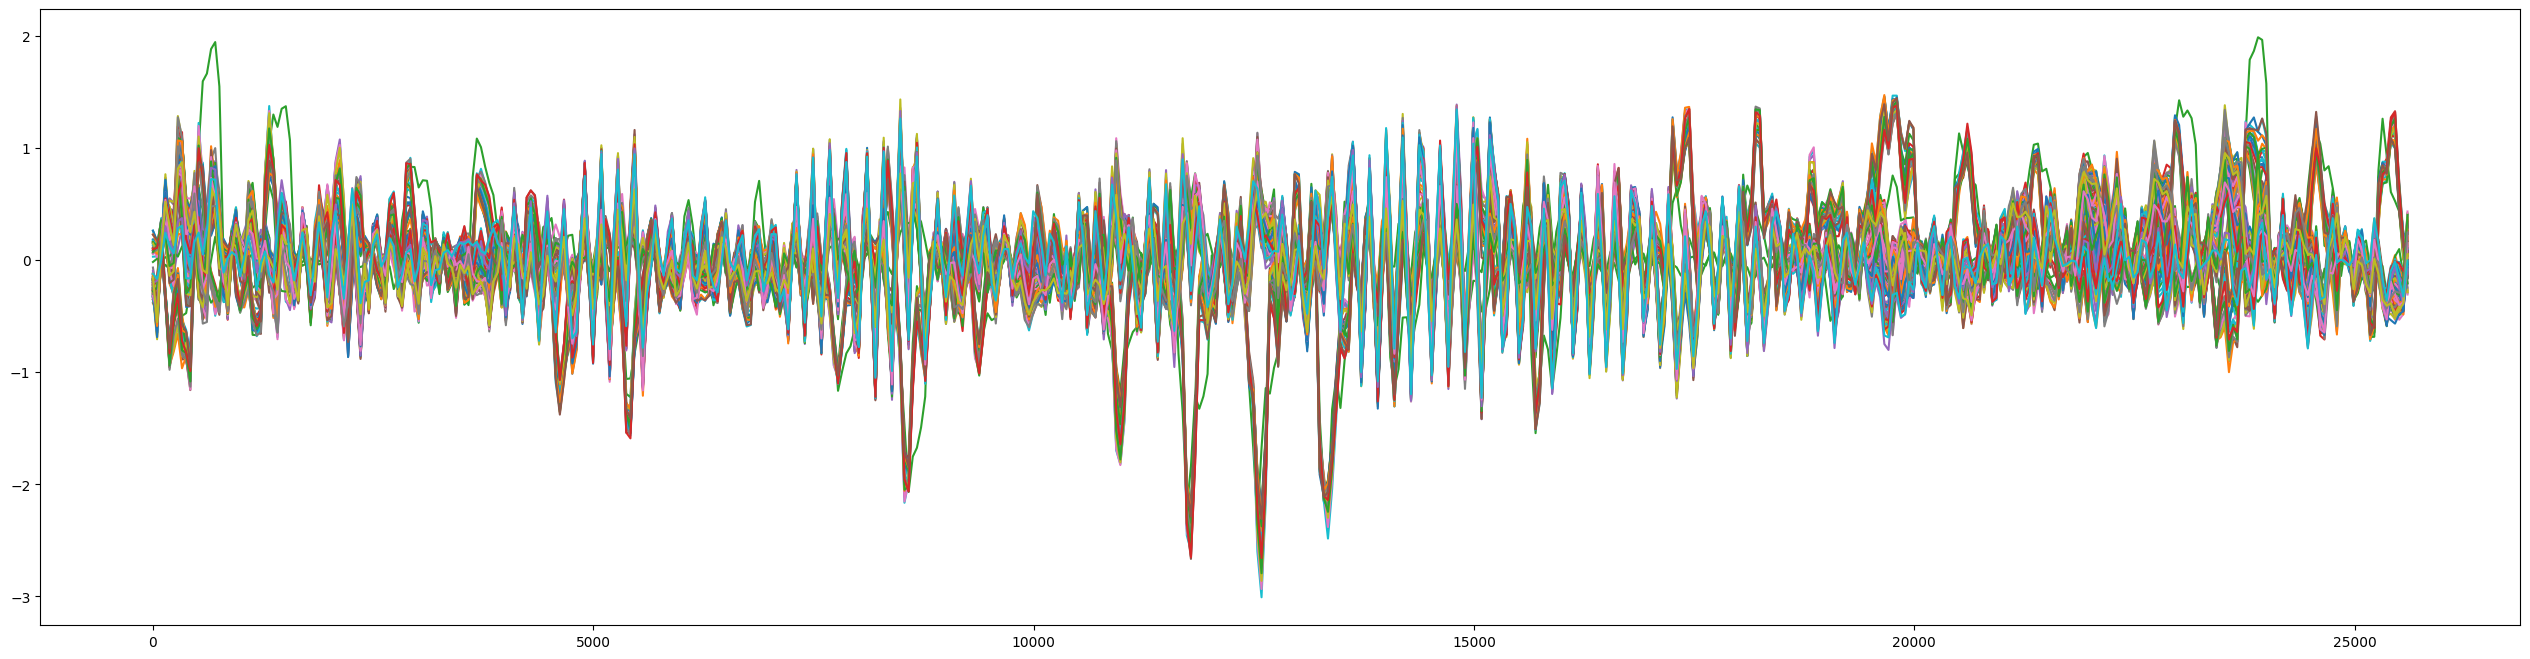

In [ ]:
# Plotting
t = np.linspace(0, 32*800 , X_train.shape[1])
plt.figure(figsize=(32,8))

for trial in range(X_train.shape[0]):
  plt.plot(t,X_train[trial])
plt.show()